In [1]:
import sys
from importlib import reload 
sys.path.append('../hdssm_story/lib')

In [2]:
import utils  # expand_to_hyperboloid
utils = reload(utils)

import distances  # Distances, ProductDistances
distances = reload(distances)
from distances import Distances, ProductDistances

import dssm  # DSSM_V2
dssm = reload(dssm)

import layers  # SphericalExponentialMapLayer, HyperbolicalExponentialMapLayer
layers = reload(layers)

__________________________

In [3]:
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import collections

from collections import defaultdict
from IPython.display import clear_output

import copy
import numpy as np
import tensorflow as tf
import pandas as pd

import scipy.stats as sps
import pickle

assert int(tf.__version__.split(".")[0]) >= 2

____________________
# Load data

In [4]:
train = pd.read_csv("../hdssm_story/true_dssm/req_ans_learn.tsv", sep="\t", header=None)
np.random.seed(17)
train["rnd"] = np.random.rand(len(train))
train = train.sort_values("rnd")
train.head()

,0,1,rnd
144284,u.2,/wiki/U2,2.456372e-07
170822,Kris Wallace,/wiki/Chris_Wallace,1.309875e-06
61024,1980: Mitsubishi produces one million cars...,/wiki/Mitsubishi_Motors,4.676557e-06
201047,code napoleon,/wiki/Napoleonic_Code,1.120069e-05
305336,somersault!,/wiki/Somersault,1.305695e-05


In [5]:
def link_prepare(key):
    return key.split("/wiki/")[1].replace("_", " ")

def link_unprepare(key):
    return "/wiki/" + key.replace(" ", "_")

In [6]:
links = []
for i in tqdm.tqdm_notebook(range(len(train))):
    links.append(str(link_prepare(train.iloc[i][1])))
    # assert link_unprepare(links[-1]) == train.iloc[i][1]

train[1] = np.array(links, dtype=str)

In [7]:
train = train.drop(columns=["rnd"])
train.head()

,0,1
144284,u.2,U2
170822,Kris Wallace,Chris Wallace
61024,1980: Mitsubishi produces one million cars...,Mitsubishi Motors
201047,code napoleon,Napoleonic Code
305336,somersault!,Somersault


In [8]:
len(train.values[:, 1]), len(np.unique(train.values[:, 1]))

(491044, 66060)

__________________________
## 3-Level DSSM

In [9]:
@tf.custom_gradient
def stop_nan_grad(x):  # fix numerical problems with some metrix on bad batches
    def grad(dx):
        if tf.math.is_nan(dx).numpy().any():
            print("NANs in grad! Batch will be ignored")
            return tf.zeros_like(dx)
        else:
            return dx
    return x, grad


class DSSM_3_Layers(dssm.DSSM_V2):
    def __init__(self, emb_size=30, hid_size=256, use_dropout=False):
        super(DSSM_3_Layers, self).__init__(emb_size=emb_size, hid_size=hid_size, wh_buckets=30000)
        self.train = False
        self.use_dropout = use_dropout
        
    def init_layers(self):
        self.dense_in_1 = tf.keras.layers.Dense(self.cfg["hid_size"] * 2, activation=self.cfg["activation"])
        self.drop_in_1 = tf.keras.layers.Dropout(0.1)
        self.dense_in_2 = tf.keras.layers.Dense(self.cfg["hid_size"], activation=self.cfg["activation"])
        self.drop_in_2 = tf.keras.layers.Dropout(0.1)
        self.dense_in_3 = tf.keras.layers.Dense(self.cfg["emb_size"], activation=None)

        self.dense_out_1 = tf.keras.layers.Dense(self.cfg["hid_size"] * 2, activation=self.cfg["activation"])
        self.drop_out_1 = tf.keras.layers.Dropout(0.1)
        self.dense_out_2 = tf.keras.layers.Dense(self.cfg["hid_size"], activation=self.cfg["activation"])
        self.drop_out_2 = tf.keras.layers.Dropout(0.1)
        self.dense_out_3 = tf.keras.layers.Dense(self.cfg["emb_size"], activation=None)
        
    def get_weights(self):
        return (
            self.dense_in_1.weights
            + self.dense_in_2.weights
            + self.dense_in_3.weights
            + self.dense_out_1.weights
            + self.dense_out_2.weights
            + self.dense_out_3.weights 
        )
    
    def call_query(self, q):
        x = q
        x = self.dense_in_1(x)
        x = self.drop_in_1(x, training=self.train and self.use_dropout)
        x = self.dense_in_2(x)
        x = self.drop_in_2(x, training=self.train and self.use_dropout)
        x = self.dense_in_3(x)
        return stop_nan_grad(x) if self.train else x

    def call_doc(self, d):
        x = d
        x = self.dense_out_1(x)
        x = self.drop_out_1(x, training=self.train and self.use_dropout)
        x = self.dense_out_2(x)
        x = self.drop_out_2(x, training=self.train and self.use_dropout)
        x = self.dense_out_3(x)
        return stop_nan_grad(x) if self.train else x

In [10]:
def postprocessing(trainer, d, dist, emb_name, date = "2020-05-05"):
    # save weights
    with open(emb_name + f"-{date}.pickle", "wb") as f:
        pickle.dump(trainer.best_model_weights + trainer.best_dist_weights, f)
    
    # restore best model
    for w, b_w in zip(d.get_weights(), trainer.best_model_weights):
        w.assign(b_w)

    for w, b_w in zip(dist.get_weights(), trainer.best_dist_weights):
        w.assign(b_w)

    # print stats
    print("TRAIN:", trainer.get_train_acc(d, dist, return_metrics=True))
    print("VAL:", trainer.get_val_acc(d, dist, return_metrics=True))
    print("TEST:", trainer.get_test_acc(d, dist, return_metrics=True, bug_fixed=True))
    # 3% of test-data was also val-data

_________________
## Tiny DSSM

In [16]:
d = DSSM_3_Layers(hid_size=256, emb_size=10)
dist = ProductDistances([
    (10, Distances("triple_trainable_l1_ex_corrected", dtype=tf.float32)),
])

In [17]:
trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=99999,
    tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})

100%|██████████| 441939/441939 [00:00<00:00, 685103.32it/s]


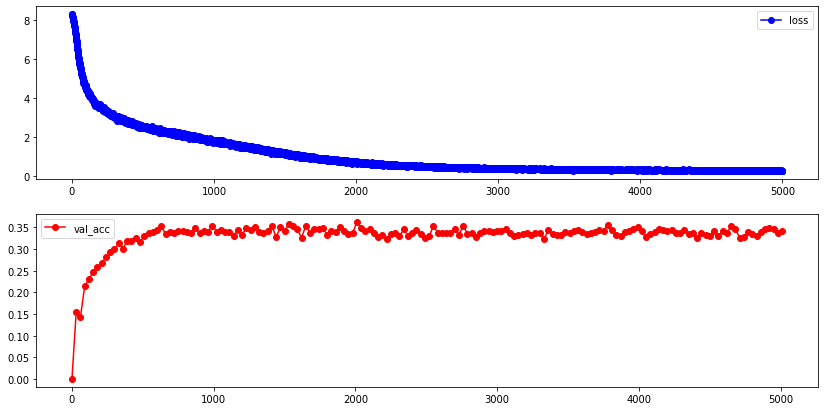

val_acc[-1] = 0.341


In [18]:
trainer.fit(d, dist, redraw_interval=30, iters=5000)

In [19]:
postprocessing(trainer, d, dist, "dssm-exp-10-triple_trainable_l1_ex_corrected")

TRAIN: {'hits': 6443, 'total': 10000, 'map100': 0.7429600310930857, 'acc': 0.6443}


VAL: {'hits': 363, 'total': 1000, 'map100': 0.43042491330851834, 'acc': 0.363}


TEST: {'hits': 17739, 'total': 48105, 'map100': 0.4447777754957858, 'acc': 0.368755846585594}


In [20]:
d = DSSM_3_Layers(hid_size=256, emb_size=10)
dist = ProductDistances([
    (10, Distances("triple_trainable_l1_sq_ex_corrected", dtype=tf.float32)),
])

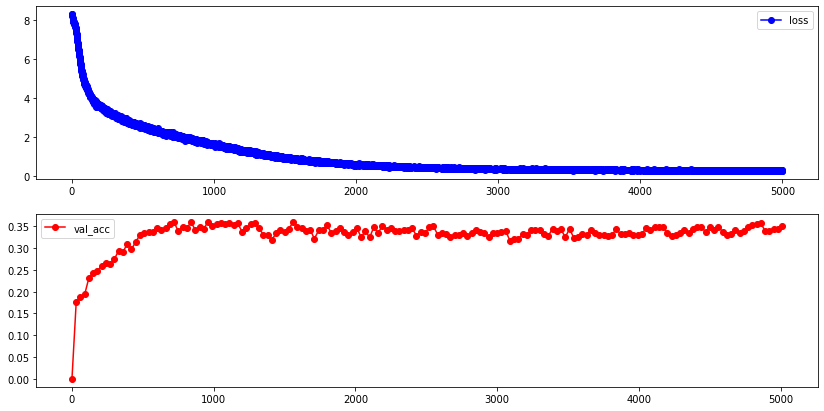

val_acc[-1] = 0.35


In [21]:
trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=99999,
    tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})
trainer.fit(d, dist, redraw_interval=30, iters=5000)

In [22]:
postprocessing(trainer, d, dist, "dssm-exp-10-triple_trainable_l1_sq_ex_corrected")

TRAIN: {'hits': 4842, 'total': 10000, 'map100': 0.5756755973036691, 'acc': 0.4842}


VAL: {'hits': 360, 'total': 1000, 'map100': 0.43100096301767926, 'acc': 0.36}


TEST: {'hits': 18103, 'total': 48105, 'map100': 0.4483005053439361, 'acc': 0.37632262758549007}


In [29]:
d = DSSM_3_Layers(hid_size=256, emb_size=10)
dist = ProductDistances([
    (2, Distances("hyperspherical", scalable=True, dtype=tf.float32)),
    (2, Distances("hyperspherical", scalable=True, dtype=tf.float32)),
    (2, Distances("hyperspherical", scalable=True, dtype=tf.float32)),
    (2, Distances("hyperspherical", scalable=True, dtype=tf.float32)),
    (2, Distances("hyperspherical", scalable=True, dtype=tf.float32)),
])

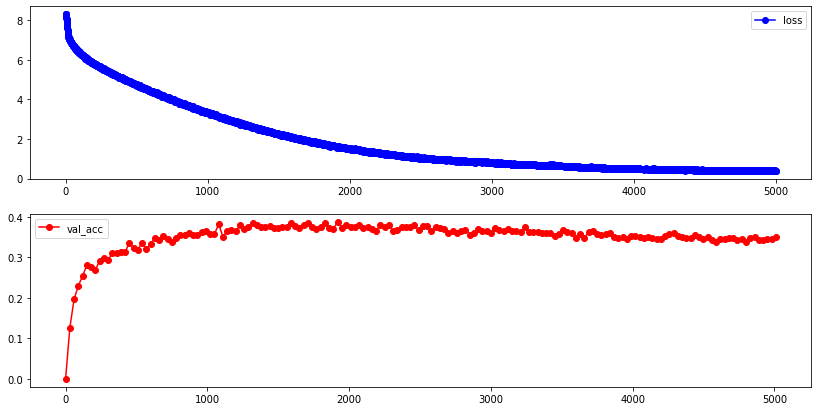

val_acc[-1] = 0.35


In [30]:
trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=99999,
    tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})
trainer.fit(d, dist, redraw_interval=30, iters=5000)

In [32]:
postprocessing(trainer, d, dist, "dssm-exp-10-s_2_5")

Bad spherical cosine = -1.0000001192092896, 0.9999998211860657
Bad spherical cosine = -1.0000001192092896, 0.9999998211860657
Bad spherical cosine = -1.0000001192092896, 1.0000001192092896
Bad spherical cosine = -1.0000001192092896, 1.0
Bad spherical cosine = -1.0000001192092896, 0.9999999403953552
Bad spherical cosine = -1.0000001192092896, 0.9999998211860657
Bad spherical cosine = -0.9999998211860657, 1.0000001192092896
Bad spherical cosine = -1.0000001192092896, 0.9999997019767761
Bad spherical cosine = -0.9999998807907104, 1.0000001192092896
Bad spherical cosine = -1.0000001192092896, 0.9999423623085022
Bad spherical cosine = -1.0, 1.0000001192092896
Bad spherical cosine = -1.0000001192092896, 0.9999991059303284
Bad spherical cosine = -0.9999991059303284, 1.0000001192092896
Bad spherical cosine = -0.9999966025352478, 1.0000001192092896
Bad spherical cosine = -0.9999964237213135, 1.0000001192092896
Bad spherical cosine = -0.9999904632568359, 1.0000001192092896
Bad spherical cosine =

Bad spherical cosine = -0.9999597072601318, 1.0000001192092896
Bad spherical cosine = -0.9999973177909851, 1.0000001192092896
Bad spherical cosine = -0.999997615814209, 1.0000001192092896
VAL: {'hits': 388, 'total': 1000, 'map100': 0.4388022579383176, 'acc': 0.388}


Bad spherical cosine = -1.0000001192092896, 1.0
Bad spherical cosine = -1.0, 1.0000001192092896
Bad spherical cosine = -1.0000001192092896, 0.9999913573265076
Bad spherical cosine = -1.0, 1.0000001192092896
Bad spherical cosine = -0.9999901652336121, 1.0000001192092896
Bad spherical cosine = -1.0000001192092896, 0.9999970197677612
Bad spherical cosine = -0.9998699426651001, 1.0000001192092896
Bad spherical cosine = -1.0000001192092896, 0.9999537467956543
Bad spherical cosine = -1.0000001192092896, 0.9999982118606567
Bad spherical cosine = -0.9999991059303284, 1.0000001192092896
Bad spherical cosine = -1.0000001192092896, 1.0
Bad spherical cosine = -1.0000001192092896, 0.9999984502792358
Bad spherical cosine = -1.0000001192092896, 0.9999999403953552
Bad spherical cosine = -1.0000001192092896, 0.9999999403953552
Bad spherical cosine = -1.0000001192092896, 1.0
Bad spherical cosine = -0.999994158744812, 1.0000001192092896
Bad spherical cosine = -0.9999924302101135, 1.0000001192092896
Bad s

In [33]:
d = DSSM_3_Layers(hid_size=256, emb_size=10)
dist = ProductDistances([
    (2, Distances("hyperspherical", scalable=True, dtype=tf.float32)),
    (2, Distances("hyperspherical", scalable=True, dtype=tf.float32)),
    (2, Distances("expanded_hyp", scalable=True, dtype=tf.float32)),
    (2, Distances("expanded_hyp", scalable=True, dtype=tf.float32)),
    (2, Distances("euclidian", scalable=True, dtype=tf.float32)),
])

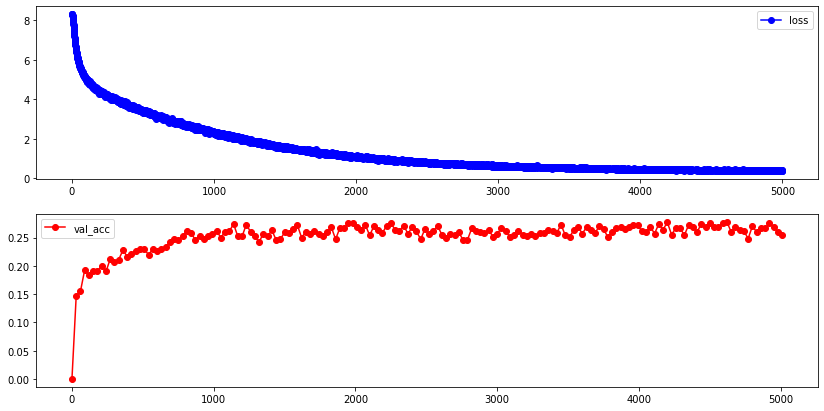

val_acc[-1] = 0.255


In [34]:
trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=99999,
    tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})
trainer.fit(d, dist, redraw_interval=30, iters=5000)

In [36]:
postprocessing(trainer, d, dist, "dssm-exp-10-s_2_2_h_2_2_e_2_1")

Bad hyperbolical dot = -0.9999847412109375
Bad spherical cosine = -1.0, 1.0000001192092896
Bad hyperbolical dot = -0.99993896484375
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999542236328125
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.999969482421875
Bad hyperbolical dot = -0.9999961853027344
Bad spherical cosine = -0.9999804496765137, 1.000000

Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.999969482421875
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.99993896484375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999847412109375
VAL: {'hits': 278, 'total': 1000, 'map100': 0.3256523835740537, 'acc': 0.278}


Bad spherical cosine = -0.9999924302101135, 1.0000001192092896
Bad spherical cosine = -1.0000001192092896, 0.9999998807907104
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.999969482421875
Bad hyperbolical dot = -0.999969482421875
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.999969482421875
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.999969482421875
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical d

Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.999969482421875
Bad hyperbolical dot = -0.9999980926513672
Bad hyperbolical dot = -0.999969482421875
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.999969482421875
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.999969482421875
Bad hyperbolical dot = -0.99993896484375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical 

Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999980926513672
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad spherical cosine = -1.0000001192092896, 0.9999598860740662
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999923706054688
Bad hyperbolical dot = -0.9999961853027344
Bad hyperbolical dot = -0.9999847412109375
Bad hyperbolical dot = -0.9999961853027344
Bad spherical cosine = -0.999998927116394, 1.0000001192092896
Bad spherical cosine = -1.0000001192092896, 1.0
Bad hyperb

In [37]:
d = DSSM_3_Layers(hid_size=256, emb_size=10)
dist = ProductDistances([
    (5, Distances("hyperspherical", scalable=True, dtype=tf.float32)),
    (5, Distances("expanded_hyp", scalable=True, dtype=tf.float32)),
])

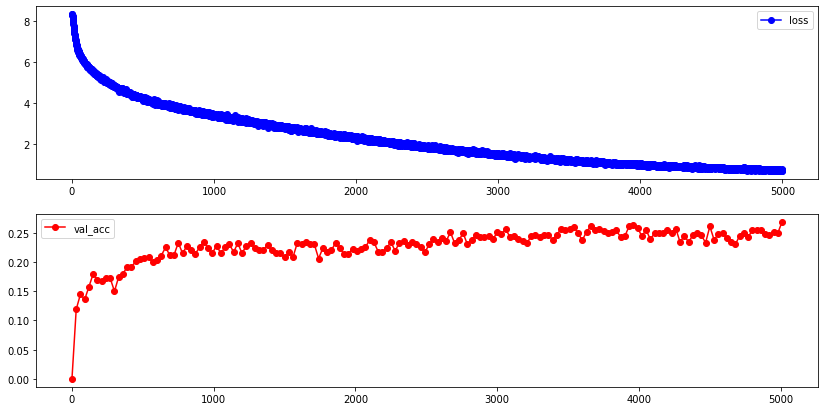

val_acc[-1] = 0.269


In [38]:
trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=99999,
    tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})
trainer.fit(d, dist, redraw_interval=30, iters=5000)

In [39]:
postprocessing(trainer, d, dist, "dssm-exp-10-h_5_2_s_5_2")

TRAIN: {'hits': 7554, 'total': 10000, 'map100': 0.8224182382130886, 'acc': 0.7554}


VAL: {'hits': 269, 'total': 1000, 'map100': 0.3190964401659457, 'acc': 0.269}


TEST: {'hits': 13012, 'total': 48105, 'map100': 0.3295781619929562, 'acc': 0.27049163288639433}


In [40]:
d = DSSM_3_Layers(hid_size=256, emb_size=10)
dist = ProductDistances([
    (5, Distances("hyperspherical", scalable=True, dtype=tf.float32)),
    (5, Distances("hyperspherical", scalable=True, dtype=tf.float32)),
])

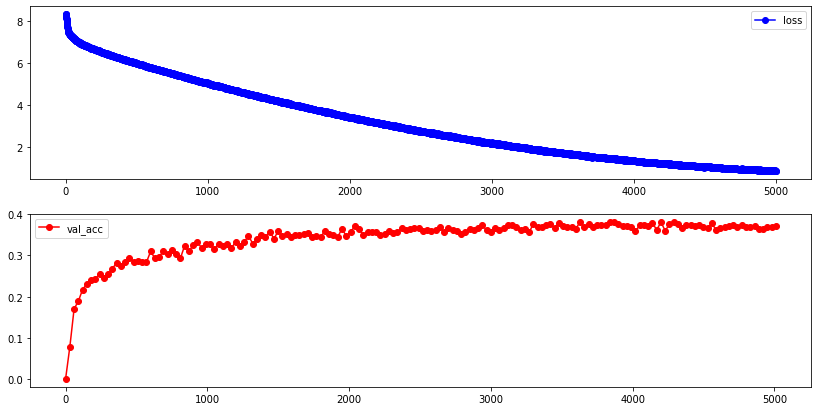

val_acc[-1] = 0.371


In [41]:
trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=99999,
    tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})
trainer.fit(d, dist, redraw_interval=30, iters=5000)

In [42]:
postprocessing(trainer, d, dist, "dssm-exp-10-s_5_2_s_5_2")

TRAIN: {'hits': 9097, 'total': 10000, 'map100': 0.9320529425478844, 'acc': 0.9097}


VAL: {'hits': 382, 'total': 1000, 'map100': 0.43485689959935375, 'acc': 0.382}


TEST: {'hits': 19382, 'total': 48105, 'map100': 0.457327031894612, 'acc': 0.4029103003845754}


In [43]:
d = DSSM_3_Layers(hid_size=256, emb_size=10)
dist = ProductDistances([
    (10, Distances("hyperspherical", scalable=True, dtype=tf.float32))
], "sum")

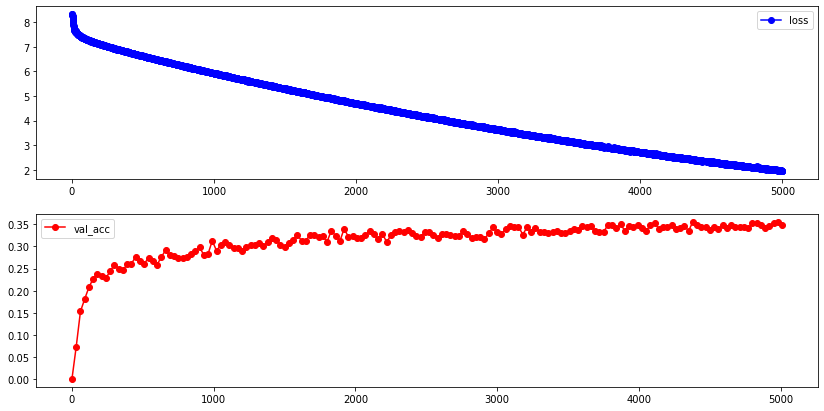

val_acc[-1] = 0.348


In [44]:
trainer = dssm.trainer.DssmTrainerWithCustomTokenizerAndHards(model=d, qs=train, hard_every=99999,
    tokenizer_cfg={"total_tokens":30000, "triplets_weight":20, "pairs_weight":2, "words_weight":8})
trainer.fit(d, dist, redraw_interval=30, iters=5000)

In [45]:
postprocessing(trainer, d, dist, "dssm-exp-10-s_10")

TRAIN: {'hits': 9121, 'total': 10000, 'map100': 0.9347517149292908, 'acc': 0.9121}


VAL: {'hits': 356, 'total': 1000, 'map100': 0.4094570275097842, 'acc': 0.356}


TEST: {'hits': 18287, 'total': 48105, 'map100': 0.43642301817097295, 'acc': 0.38014759380521773}
